In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
files = os.listdir('./')
files = list(filter(lambda s: s.endswith('.txt'), files))
files

['compound_category.txt',
 'price_length.txt',
 'rating_category.txt',
 'rating_compound.txt',
 'rating_length.txt']

In [3]:
# 0: sort by value, 1: sort by ticks
sort_ticks = {'compound_category.txt': 0,
              'price_length.txt': 1,
              'rating_category.txt': 0,
              'rating_compound.txt': 1,
              'rating_length.txt': 1}

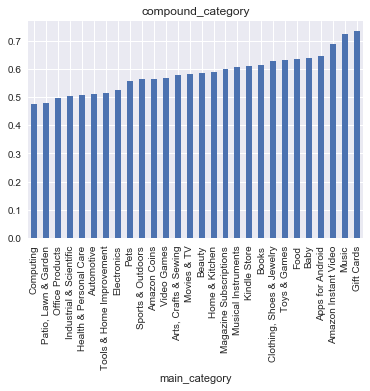

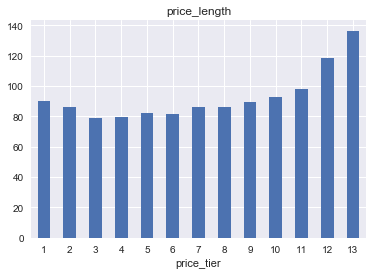

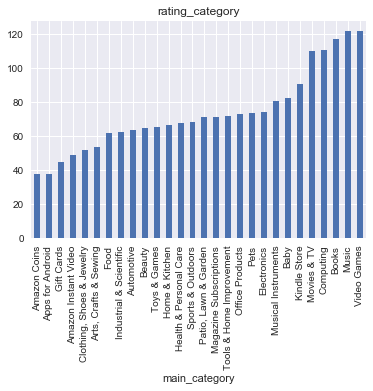

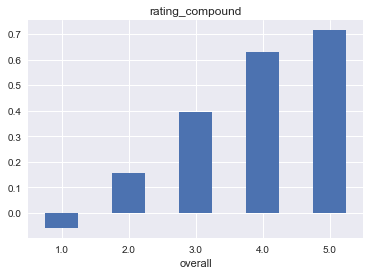

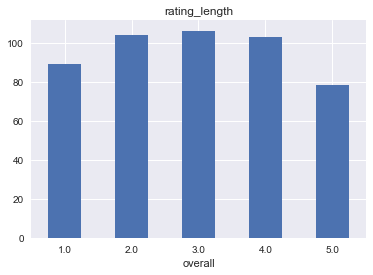

In [4]:
# file = files[0]
for file in files:
    with open(file) as f:
        data = eval(f.read())
    df = pd.DataFrame(data)
    if sort_ticks[file]:
        df.sort_values(df.columns[1], inplace=True)
        rotation = 0
    else:
        df.sort_values(df.columns[0], inplace=True)
        rotation = 90
    df.plot(x=df.columns[1], y=df.columns[0], kind='bar',
            legend=False, grid=True)
    plt.xticks(rotation=rotation)
    plt.title(file[:-4])
    
    plt.gcf().savefig(file[:-3]+'png', bbox_inches='tight')